In [1]:
HOST = '37.139.42.145'
DBNAME = 'game-analytics'
USER = 'analytics'
PASSWORD = '************'
import pandas as pd
from sqlalchemy import create_engine
engine = create_engine(f'postgresql://{USER}:{PASSWORD}@{HOST}/{DBNAME}')
TABLE_SCHEMA ='data_viz_1068.project_dataset'

In [2]:
rr=pd.read_sql(f'''
with data as

         (SELECT  event_time, user_id, platform, 
            min(event_time) filter (where event_name='FirstLaunchApp') OVER(PARTITION BY user_id) as date_install,
            user_type
            FROM data_viz_1068.project_dataset
            WHERE user_id in
                    (SELECT user_id
                    FROM data_viz_1068.project_dataset
                    WHERE event_name='FirstLaunchApp')),
temp_df as(
        SELECT case when user_id>0 then '1' end as  merge,(ROW_NUMBER() OVER())-1 num
        FROM data_viz_1068.project_dataset
        WHERE event_name='FirstLaunchApp'
        LIMIT 90)
    SELECT lifetime, 100-cast(users as float)/cast(max as float)*100 as churn_rate, platform,user_type
    FROM
        (SELECT num as lifetime, count(distinct user_id) as users,platform, user_type,
        max(count(distinct user_id)) over (partition by platform,user_type) as max
        FROM
            (SELECT lifetime,num, user_id,platform,user_type
                FROM
                (SELECT *
                    FROM (SELECT max(extract(day from date_trunc('days',event_time-date_install)/7)) as lifetime,
                    user_id, platform, user_type, case when user_id>0 then '1' end as  merge
                    FROM data
                    WHERE event_time <=(date_install+INTERVAL '3' MONTH) 
                    GROUP BY 2,3,4
                    ORDER BY 1) as p
                    JOIN temp_df  as k
                    ON p.merge=k.merge) as datas
                WHERE lifetime>=num 
            ) as y
    GROUP BY 1,3,4)as e
    ORDER BY 1
''', con=engine)

In [3]:
rr

,lifetime,churn_rate,platform,user_type
0,0,0.000000,android,non_organic
1,0,0.000000,ios,organic
2,0,0.000000,android,organic
3,0,0.000000,ios,non_organic
4,1,75.633817,android,organic
5,1,71.977330,android,non_organic
6,1,68.250000,ios,non_organic
7,1,73.983677,ios,organic
8,2,80.736064,ios,organic
9,2,79.219144,android,non_organic


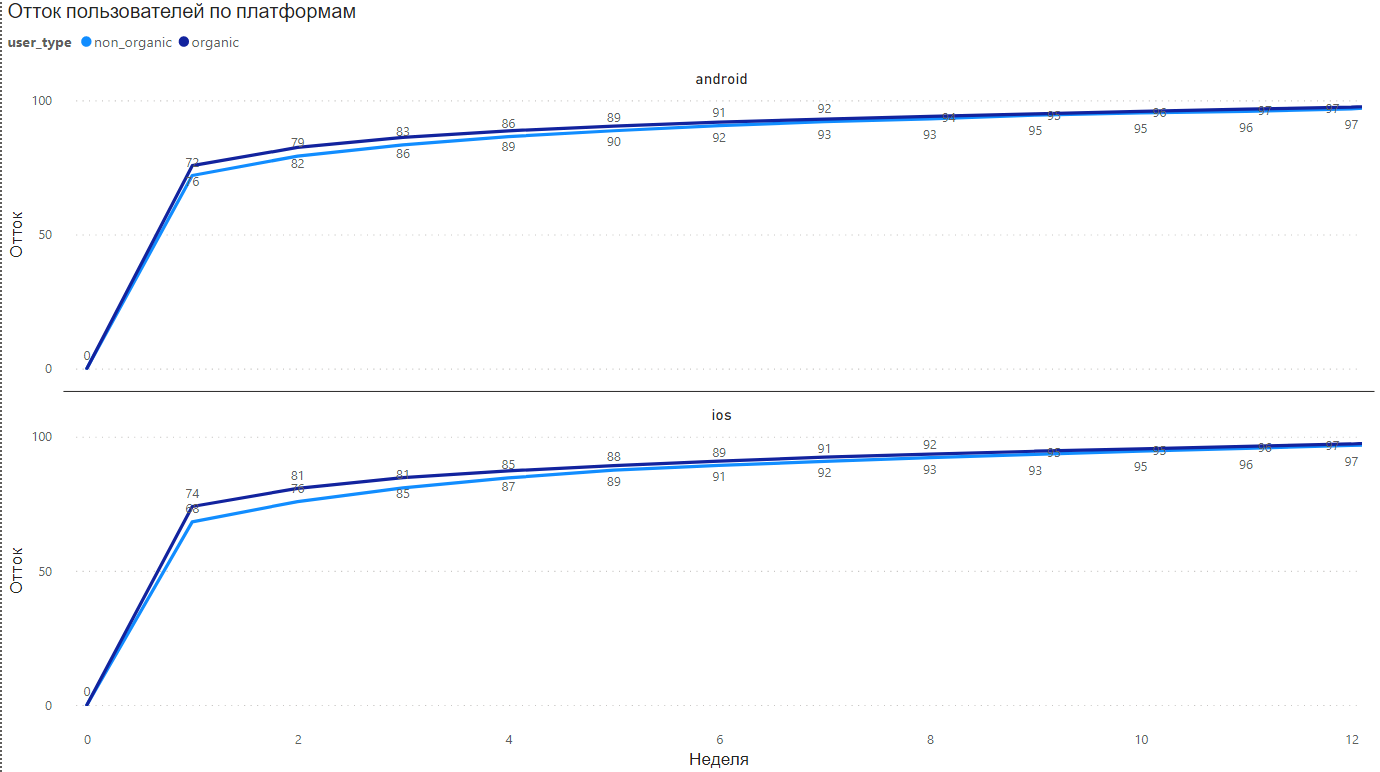

Вывод:Графики по когортам, почти не отличаются, то есть отток пользователей идет в примерно равном объеме. Наибольший отток пользователей происходит в первую неделю, почти незаметный отток начинается примерно после 5 недели. Неорганический трафик имеет меньший показатель на платформе ios, а органический на платформе android.